# Raw data importing
Our primary goal here is to import, interpolate, and extend our bike riding GPS data. It'll be somewhat complicated as it is not small task on code, but using vectorization on all processes will keep execution really fast. We have for this task about 1.7M datapoints. Each datapoint corresponds to a fancy **one point in space time**, i.e. one point made of 4 dimensions of timestamp, latitude, longitude and elevation. We hope that connection each one sequentially on time will render a path that a biker rode. To guarantee bookeeping and post processing capabilities, we will record the point id, ride id and rider id.

In [654]:
# import needed packages
import gpxpy
import datetime 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import numpy as np
import re
import sys
import pandas as pd
import pickle as pk
from tqdm import tqdm_notebook as tqdm
from geopy.distance import great_circle
# from scipy.signal import gaussian
# from scipy.ndimage import filters
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nvector as nv
from pandas.plotting import andrews_curves

In [744]:
# import the gpx data
gpx_filename_pattern = re.compile("(gpx)$")
def build_meta(gpx): 
    meta = {
        "tracks": 0,
        "segments": 0,
        "points": 0
    }
    for track in gpx.tracks:
        meta["tracks"] += 1
        for segment in track.segments:
            meta["segments"] += 1
            for point in segment.points:
                meta["points"] += 1
    return meta

def import_gpx_file(path, filename):
    build_meta
    file = open(path+'/'+filename, 'r')
    gpx = gpxpy.parse(file)
    meta = build_meta(gpx)
    data = np.zeros((meta['points'], 5))
    n = 0
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                t = time.mktime(point.time.timetuple())
                data[n, ] = [point.latitude, point.longitude, point.elevation, t, n]
                n += 1
    return pd.DataFrame({
        'latitude': data[:,0],
        'longitude': data[:,1],
        'elevation': data[:,2],
        'timestamp': data[:,3],
        'point': data[:,4],
        'ride': 0,
        'rider': ""
    })

def import_gpx_dir(path):
    filenames = [f for f in os.listdir(path) if gpx_filename_pattern.search(f)]    
    data = pd.DataFrame()
    n = 0
    for filename in tqdm(filenames, total=len(filenames)):
        dt = import_gpx_file(path, filename)
        dt['ride'] = n
        n += 1
        data = data.append(dt, ignore_index=True)
    return data

def interpret_gpx(path, name):
    data = import_gpx_dir(path)
    data["rider"] = name
    data.elevation = data.elevation.astype(int)
    data.timestamp = data.timestamp.astype(int)
    data.point = data.point.astype(int)
    #save to cache
    cache = open(str(name)+'.pkl', 'wb')
    pk.dump(data, cache)
    cache.close()
    return data

def load_gpx(path):
    cache = open(path, 'rb')
    data = pk.load(cache)
    cache.close()
    return data

def save_data(data, name):
    cache = open(name+".pkl", 'wb')
    pk.dump(data, cache)
    cache.close()
    
def load_data(name):
    cache = open(name+".pkl", 'rb')
    data = pk.load(cache)
    cache.close()
    return data

if(os.path.exists("0.pkl")):
    data1 = load_gpx("0.pkl")
    data2 = load_gpx("1.pkl")
else:
    data1 = interpret_gpx("/Users/esse/activ/rodrigo_sztelzer", 0)
    data2 = interpret_gpx("/Users/esse/activ/marcos_paulo", 1)

data = data1.append(data2, ignore_index=True)
print(data.shape)
print(data.head())

(1739684, 7)
   elevation   latitude  longitude  point  ride  rider   timestamp
0        747 -23.562747 -46.691410      0     0      0  1496509570
1        749 -23.562589 -46.691241      1     0      0  1496509607
2        750 -23.562554 -46.691224      2     0      0  1496509609
3        750 -23.562522 -46.691213      3     0      0  1496509610
4        750 -23.562473 -46.691212      4     0      0  1496509611


# Data processing
There will have some steps to have a gooda data shaped to most processes. The idea is to cleanup dirt distances introduced by bad GPS and interpolate the points as to make all rows 1 meter of distance, that will simplify most phisical calculations.

####  Create destination columns
This will transform the list in a origin/destination list of points, so the resulting list is [M-1, N*2]. These new columns are equal to the next row. Finally remove the last element of each ride that has value zero.

In [745]:
# create a column with the next points
dt = data.copy()
# del(dt['longitude'])
# del(dt['latitude'])
dt['ilon'] = data['longitude']
dt['ilat'] = data['latitude']
dt['itime'] = dt['timestamp']
dt['ielev'] = dt['elevation']

dt['flon'] = np.roll(data.longitude, -1, 0)
dt['flat'] = np.roll(data.latitude, -1, 0)
dt['ftime'] = np.roll(data.timestamp, -1, 0)
dt['felev'] = np.roll(data.elevation, -1, 0)

inverseid = dt.groupby(['rider','ride']).cumcount(ascending=False)
dt = dt[inverseid > 0]

del(dt['longitude'])
del(dt['latitude'])
del(dt['timestamp'])
del(dt['elevation'])

data = dt.copy()
del(dt)

## Constant Time
We need to make time constant to see odd values and simplify most phisics calculations.

In [746]:
data = data.sort_values(['rider', 'itime'])
data['duration'] = data.ftime - data.itime

# shorten pauses longer than 1 minute.
data[data.duration > 60] == 60

#repeat the data, set repeats to nan, interpolate nans.
data = data.loc[data.index.repeat(data.duration)]
data['subindex'] = data.groupby(level=0).cumcount()
data[data.subindex > 0] = np.nan
data = data.interpolate()

# clear unused columns
del data['duration']
del data['subindex']

#### Calculate distances based on the Great Circle of Earth radius.

In [747]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return 6372800 * 2 * np.arcsin(np.sqrt(a))

data['dist'] = haversine(data.ilon, data.ilat, data.flon, data.flat)

#### Remove odd distances.
We can see in the plot that there are no strange vectors on the start and end of a ride.

In [748]:
data = data[data.dist<=20]
data = data[data.dist>0]

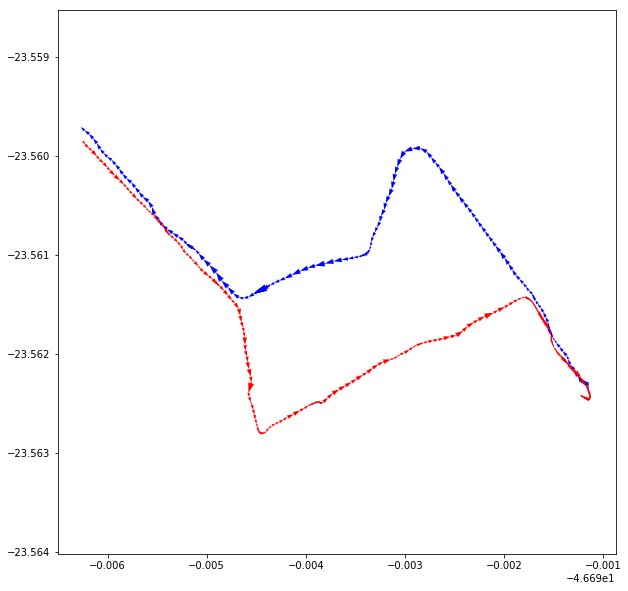

In [733]:
seg = data[data.rider==0]
seg = seg[seg.ride==1]
head = seg.head(200)
tail = seg.tail(260)

plt.figure(figsize=(10,10))
plt.quiver(head.ilon, head.ilat, head.flon-head.ilon, head.flat-head.ilat, color="blue", units='xy', angles='xy', scale=1, pivot='tail')
plt.quiver(tail.ilon, tail.ilat, tail.flon-tail.ilon, tail.flat-tail.ilat, color="red", units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')
plt.show()


In [749]:
save_data(data, "vectorized")

## Extending
Now, lets calculate other variables.

In [750]:
# create a column with angle in degrees
data['heading'] = np.arctan2(data.flon-data.ilon, data.flat-data.ilat) * 180 / np.pi
data.loc[data.point==0, 'heading'] = 0

In [751]:
# column with deltadistance (acceleration)
data['ddist'] = np.roll(data.dist, 1, 0) - data.dist
data.loc[data.point==0, 'ddist'] = 0

In [752]:
# delta elevation
data['delev'] = data.felev - data.ielev
data['delev'] = np.clip(data.delev, -1, 1)
# climbrate
data['climb'] = data.delev / data.dist
data['climb'] = np.clip(data['climb'], -1, 1)

Make a checkpoint of the data.

In [753]:
save_data(data, "extended")

In [109]:
data = load_data("extended")

# Seeing the data

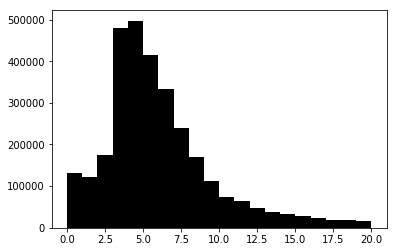

In [754]:
plt.hist(data.dist, bins=20, color='black')
plt.show()

# Simple plot one ride

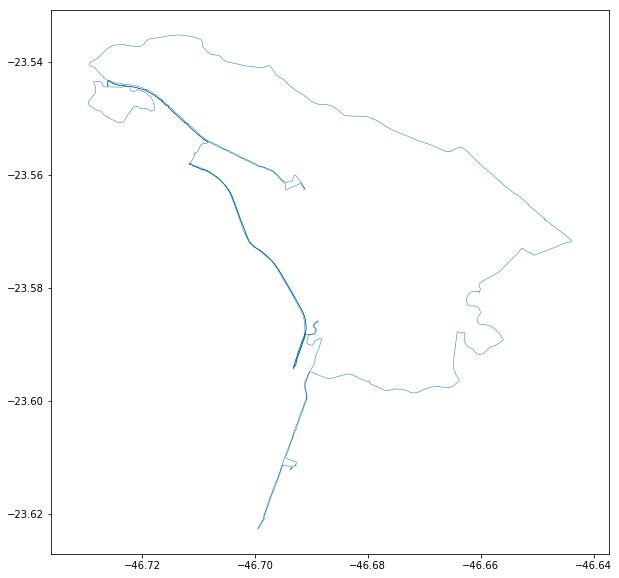

In [757]:
seg = data[data.rider==0]
seg = seg[seg.ride==0]

# this will print the sum of seconds. A greater than 2000
plt.figure(figsize=(10,10))
plt.subplot(111).plot(seg.ilon, seg.ilat, linewidth=0.5)
plt.axis('equal')
plt.show()

# Viewing the Speed

In [761]:
seg = data.copy()

seg = seg[seg.ilat > -23.63] #east boundary
seg = seg[seg.ilat < -23.50] #west boundary
seg = seg[seg.ilon > -46.76] #north boundary
seg = seg[seg.ilon < -46.60] #south boundary

seg['glat'] = np.around(seg.ilat, 4)
seg['glon'] = np.around(seg.ilon, 4)
seg['gdir'] = round(seg.heading/45)*45

group = seg.groupby(['glat', 'glon', 'gdir'], axis=0)
distancemean = pd.DataFrame(group['dist'].mean())
latmean = pd.DataFrame(group['ilat'].mean())
lonmean = pd.DataFrame(group['ilon'].mean())

seg = seg.merge(latmean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
seg = seg.merge(lonmean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
seg = seg.merge(distancemean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))

seg = seg.sort_values(['rider', 'itime'])

In [767]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

xy = seg[['flon','flat']]
# xy = pd.DataFrame([lonmean, latmean])
di = seg[['dist']]

s = pd.DataFrame(scaler.fit_transform(xy), columns=["ilon", "ilat"])
s = (s - 0.38) * 8

color = pd.DataFrame(scaler.fit_transform(di))

from vispy import app
from vispy import gloo
c = app.Canvas(keys='interactive')

vertex = """
attribute vec2 a_position;
void main (void)
{
    gl_Position = vec4(a_position, 0.0, 1.0);
}
"""

fragment = """
void main()
{
    gl_FragColor = vec4(0.0, 0.0, 0.0, 1.0);
}
"""
program = gloo.Program(vertex, fragment)

program['a_position'] = np.c_[s.astype(np.float32)]

@c.connect
def on_resize(event):
    gloo.set_viewport(1, 1, *event.size)

@c.connect
def on_draw(event):
    gloo.clear((1,1,1,1))
    program.draw('line_strip')
    
c.show()
app.run()

  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
